<a href="https://colab.research.google.com/github/tomhyhan/noodles/blob/main/pasta_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import userdata
from google.colab import auth

auth.authenticate_user()
token = userdata.get('token')
username = userdata.get('username')
repo_name = "noodles"

In [3]:
import os

!git clone https://github.com/tomhyhan/{repo_name}.git

if os.getcwd() != f"/content/{repo_name}":
    %cd {repo_name}
!git pull
!pwd


fatal: destination path 'noodles' already exists and is not an empty directory.
/content/noodles
Already up to date.
/content/noodles


In [4]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "noodles"

GOOGLE_DRIVE_PATH = os.path.join("..", "drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


In [6]:
from model.utils import test_colab
test_colab()


Hello Colab! from Noodles ha


In [7]:
!pip install torchinfo
!pip install imagehash

In [8]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold


from config.config_manager import ConfigManager
from collections import Counter
from model.data_model import PastaData, create_train_transforms, create_test_transforms
from model.train import trainer, create_model
from model.utils import reset_seed
from model.data import CLASS_ENCODER, create_csv
from model.viz import class_imbalance, draw_loss, draw_train_val_accuracy

In [9]:
config_manager = ConfigManager("./config/config.yml")

SEED = config_manager.config.seed

In [10]:
reset_seed(SEED)

In [11]:
image_path = os.path.join(GOOGLE_DRIVE_PATH, "images")
csv_file_path = os.path.join(GOOGLE_DRIVE_PATH, "pasta_data.csv")

if not os.path.exists(csv_file_path):
    create_csv(image_path, csv_file_path)

In [12]:
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "./pasta_data.csv"))
image_paths, labels = data["img_path"], data["label"]

X, test_data, y, test_label = train_test_split(image_paths.values, labels.values, train_size=0.9, random_state=SEED, shuffle=True, stratify=labels)

5032 1259


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/3:   0%|          | 0/235 [00:00<?, ?it/s]

Learning Rate: [9.939310252259309e-05]
Epoch 1 Loss: 2.0708004018093678 Train Accuracy: 0.7745345744680852             Validation Accuracy: 0.725328947368421
Global gradient norm: 5.49673234883029


Epoch 2/3:   0%|          | 0/235 [00:00<?, ?it/s]

Learning Rate: [4.5946382286235996e-05]
Epoch 2 Loss: 0.6078162594044462 Train Accuracy: 0.8934840425531915             Validation Accuracy: 0.84375
Global gradient norm: 2.81038896555987


Epoch 3/3:   0%|          | 0/235 [00:00<?, ?it/s]

Learning Rate: [1.4131231431282822e-09]
Epoch 3 Loss: 0.3527322102100291 Train Accuracy: 0.913563829787234             Validation Accuracy: 0.8511513157894737
Global gradient norm: 2.335287911450841
End of Training for maxvit Model 0-fold
best accuracy: 0.8511513157894737


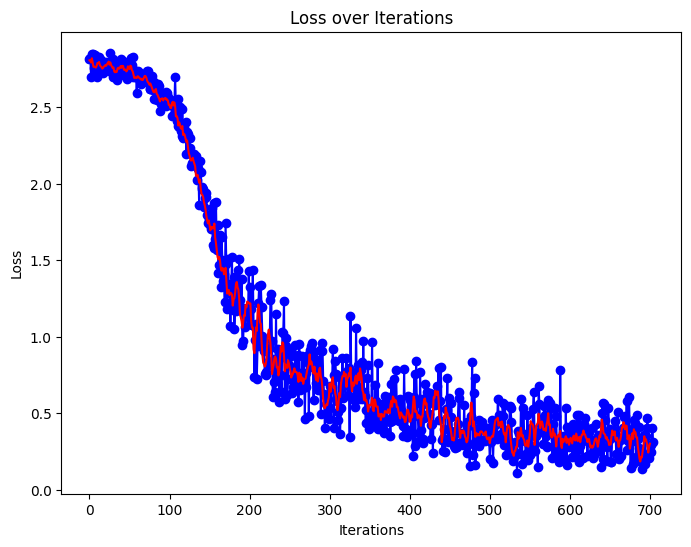

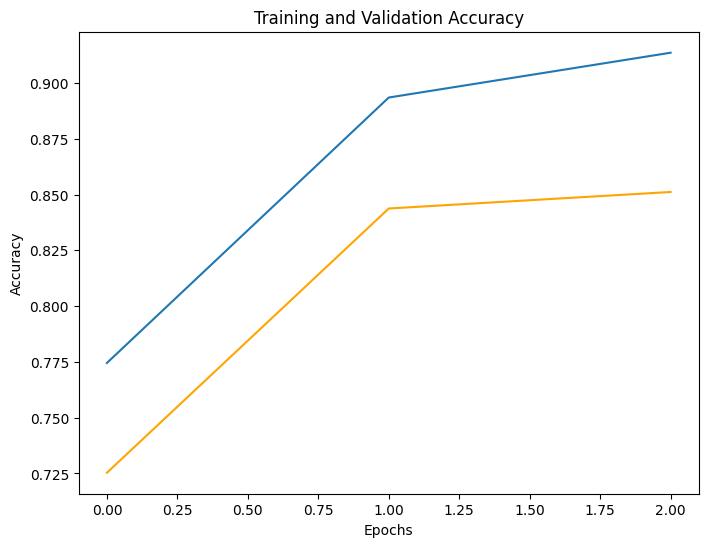

current_model_accuracies [0.8511513157894737]
5032 1259


Epoch 1/3:   0%|          | 0/235 [00:00<?, ?it/s]

Learning Rate: [9.939310252259309e-05]
Epoch 1 Loss: 1.696423935636561 Train Accuracy: 0.7628989361702128             Validation Accuracy: 0.7261513157894737
Global gradient norm: 10.904241252321972


Epoch 2/3:   0%|          | 0/235 [00:00<?, ?it/s]

Learning Rate: [4.5946382286235996e-05]
Epoch 2 Loss: 0.557176459057534 Train Accuracy: 0.8939494680851063             Validation Accuracy: 0.8199013157894737
Global gradient norm: 6.256588523356619


Epoch 3/3:   0%|          | 0/235 [00:00<?, ?it/s]

Learning Rate: [1.4131231431282822e-09]
Epoch 3 Loss: 0.2772836281898174 Train Accuracy: 0.939561170212766             Validation Accuracy: 0.8462171052631579
Global gradient norm: 5.572333067070004
End of Training for swin Model 0-fold
best accuracy: 0.8462171052631579


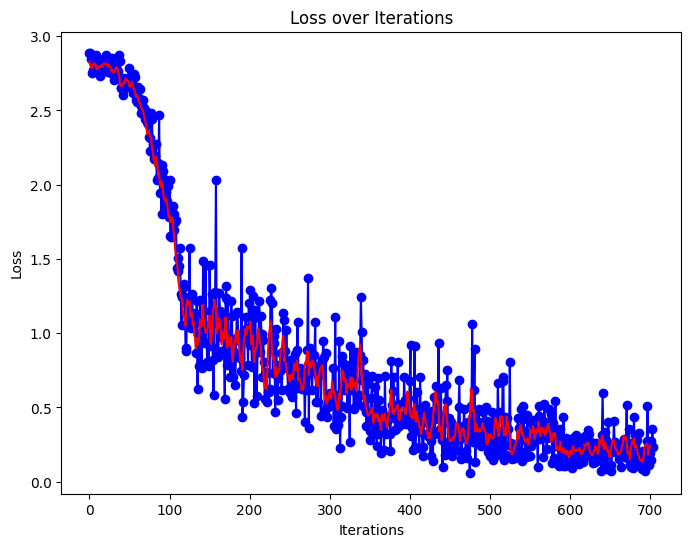

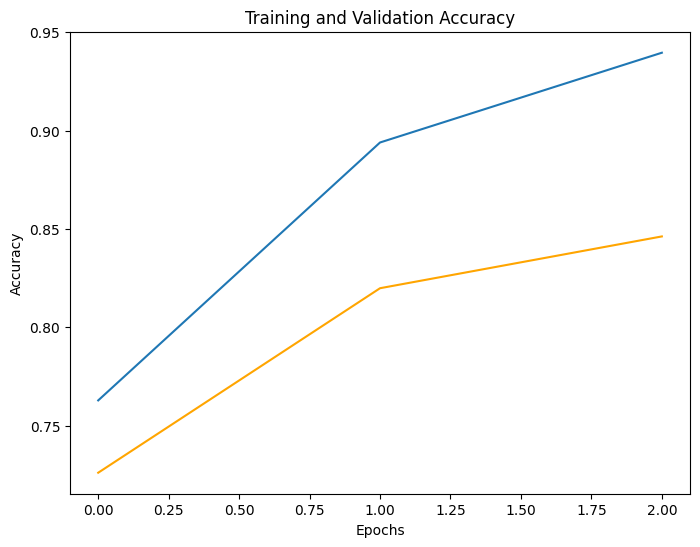

current_model_accuracies [0.8462171052631579]


In [13]:
k_fold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
models = ['maxvit','swin' ]

# N=100
# perm_indices = np.random.permutation(N)
# X = X[perm_indices]
# y = y[perm_indices]

for model_name in models:
    current_model_accuracies = []
    for k_id, (train_i, val_i) in enumerate(k_fold.split(X,y)):
        print(len(train_i), len(val_i))
        train_set = X[train_i]
        train_label_set = y[train_i]

        val_set = X[val_i]
        val_label_set = y[val_i]

        model_config = config_manager.config[model_name]
        lr = config_manager.config.lr
        num_epochs = config_manager.config.num_epochs
        num_classes = config_manager.config.num_classes
        batch_size = model_config.train_args.batch_size
        weight_decay = model_config.train_args.weight_decay
        log_interval = model_config.train_args.log_interval
        out_dir = model_config.train_args.output_dir
        scheduler_name = model_config.train_args.scheduler

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_transform = create_train_transforms()
        test_transform = create_test_transforms()

        train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
        val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

        model = create_model(model_name, num_classes)
        model.to(device)

        #  need to make dataframe from images
        loss_history, train_accuracy_history, \
        val_accuracy_history, best_accuracy, best_params = trainer(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            log_interval=log_interval,
            scheduler_name=scheduler_name,
            device=device
        )


        current_model_accuracies.append(best_accuracy)
        print(f"End of Training for {model_name} Model {k_id}-fold")
        print(f"best accuracy: {best_accuracy}")

        os.makedirs(os.path.join(GOOGLE_DRIVE_PATH, out_dir), exist_ok=True)
        torch.save(best_params, os.path.join(GOOGLE_DRIVE_PATH, out_dir, f"{model_name}_k_fold_{k_id}.pt"))
        draw_loss(loss_history)
        draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)

        break

    print("current_model_accuracies", current_model_accuracies)


        # avg_accuracy = torch.mean(fold_accuracies)
        # std_accuracy = torch.std(fold_accuracies)

        # general plan
        # 1. save best accuracies
        # 2. compare with different models
        # 3. train on full dataset with best performing model
        # 4. make inference


In [14]:
# Inference

In [16]:
# !git config pull.rebase false
# !git pull
# !git config --global user.email "tomhyhan@gmail.com"
# !git config --global user.name username
# !git add .
# !git status
# !git commit -m "updated trainer"
# !git push https://{token}@github.com/{username}/{repo_name}.git

From https://github.com/tomhyhan/noodles
   6abc802..2d87451  main       -> origin/main
Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [15]:
#